#1.Importar librerías y conjuntos de datos 

In [2]:
import pandas as pd #Manejo de dataframes
import numpy as np #Manejo de arrays
import seaborn as sns # Para realización de gráficos
import matplotlib.pyplot as plt # Para realización de gráficos
import zipfile #Para archivos comprimidos
import cv2 #Para imágenes
from skimage import io #Para imágenes
import tensorflow as tf  
from tensorflow.python.keras import Sequential #Contrucción de capas
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50 #Aprendizaje por transferencia
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model #Creación y cargue del modelo
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from google.colab import files 
%matplotlib inline

###Imprimir la versión de tensorflow

In [3]:
%tensorflow_version 2.x
import tensorflow as tf

print('Versión de Tensorflow: ' + tf.__version__)

Versión de Tensorflow: 2.8.0


###Montaje de la unidad 

In [7]:
#Se monta la unidad de drive con el fin de extraer los datos que almacenamos en esta
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Datos de imágenes con defectos con máscara

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Se define un dataframe con los datos que contienen imágenes con defectos con máscara de segmentación 
defect_class_mask_df = pd.read_csv('/content/drive/MyDrive/Proyecto_Introducción_Inteligencia_Artificial_Ejemplo_1/train.csv')

###Datos de imágenes defectuosas y no defectuosas

In [9]:
# Se define un dataframe con los datos que contienen imágenes con y sin defectos 
all_images_df = pd.read_csv('/content/drive/MyDrive/Proyecto_Introducción_Inteligencia_Artificial_Ejemplo_1/defect_and_no_defect.csv')

####Vista a los datos de imágenes defectuosas junto con su máscara de segmentación. Los números de la columna "ClassId", hacen referencia al tipo de defecto que tiene la imágen.

In [10]:
#Se imprime una vista del dataframe defect_class_mask_df
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


###Vista a los datos de imágenes defectuosas y no defectuosas. Entonces hay dos categorías: 

1. 0 No hay defecto
2. 1 Tiene defectos

In [11]:
#Se imprime una vista del dataframe all_images_df
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


#2.Exploración de los conjuntos de datos

Los datos para este trabajo fueron descargados desde https://www.kaggle.com/competitions/severstal-steel-defect-detection/rules

In [12]:
#Se agrega una columna de unos al final del conjunto de datos, esta columna se utiliza para contar el número de imagenes por categoría, es decir, 
#por 'ClassId', entonces, simplemente va a contener un uno en cada registro de la tabla. 
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [13]:
#Se imprimen los primeros 50 registros después de agregar la columna de mask 
defect_class_mask_df.head(50)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


A continuación, se presenta un gráfico que permite visualizar el número de imágenes que hay por categoría o tipo de defecto. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


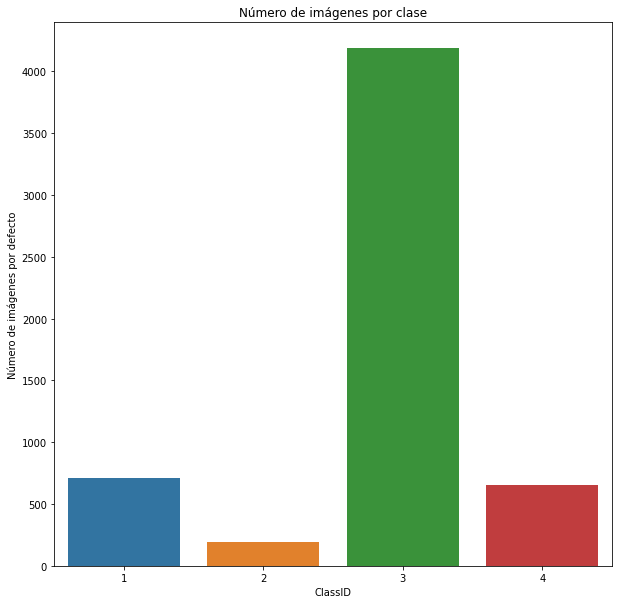

In [14]:
#Se realiza un gráfico de barras que muestre el número de imágenes por tipo de defecto 
plt.figure(figsize=(10,10))
sns.countplot(defect_class_mask_df['ClassId'])
plt.ylabel('Número de imágenes por defecto')
plt.xlabel('ClassID')
plt.title('Número de imágenes por clase')
plt.show()

Con base en el gráfico se concluye, que de la categoría 3 o del defecto número tres, es el que poseen la mayoría de las imagenes. 

In [15]:
# Algunas imágenes están clasificadas con más de un defecto, exploremos esto con más detalle.
# Entonces, se agrupan las imagenes por la columnas de ImageId y se suma la columna de mask, esto con el fin de contar 
#con una tabla que contenga la cantidad de defectos de cada imagen.
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()


In [16]:
#Se imprime el dataframe, que contiene el número de defectos que tiene cada imagen. 
defect_type.head(50)

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
0025bde0c.jpg    2
002af848d.jpg    1
002fc4e19.jpg    2
0030401a5.jpg    1
0046839bd.jpg    1
005d86c25.jpg    1
008621629.jpg    1
0088260da.jpg    1
008ef3d74.jpg    1
0095cd374.jpg    1
00ac8372f.jpg    2
00bc01bfe.jpg    1
00bf8497a.jpg    1
00c88fed0.jpg    1
00cdb56a0.jpg    1
00d639396.jpg    1
00e0398ad.jpg    1
00ec97699.jpg    1
00f1665e6.jpg    1
00f6e702c.jpg    1
01053d28f.jpg    1
010db68d1.jpg    1
012a9a4c7.jpg    1
012f26693.jpg    2
01338c0ea.jpg    1
0141c9bf3.jpg    1
0148e9891.jpg    1
014ebe543.jpg    1
01661826d.jpg    1
0167a740e.jpg    1
016af13d0.jpg    1
017c828a1.jpg    1
018ccdfed.jpg    1
01afbfa7a.jpg    1
01b043500.jpg    1
01b492dd6.jpg    1
01c3ef286.jpg    1
01cf446d4.jpg    1
01cfacf80.jpg    2
01df77e59.jpg    1
01ebe0d32.jpg    1
01fd320c9.jpg    1
01fd50e68.jpg    1
020ff3106.jpg    1
0217af9b1.jpg    1
Name: mask, dtype: int64

In [17]:
# Algunas imágenes están clasificadas con más de un defecto, exploremos esto con más detalle.
#Entonces, se cuentan las imagnes por el número de defectos y se obtiene que: 
# Hay una imagen con 3 tipos de defectos
# Hay 272 imágenes con 2 tipos de defectos
# Hay 5201 imágenes con 1 tipo de defecto
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

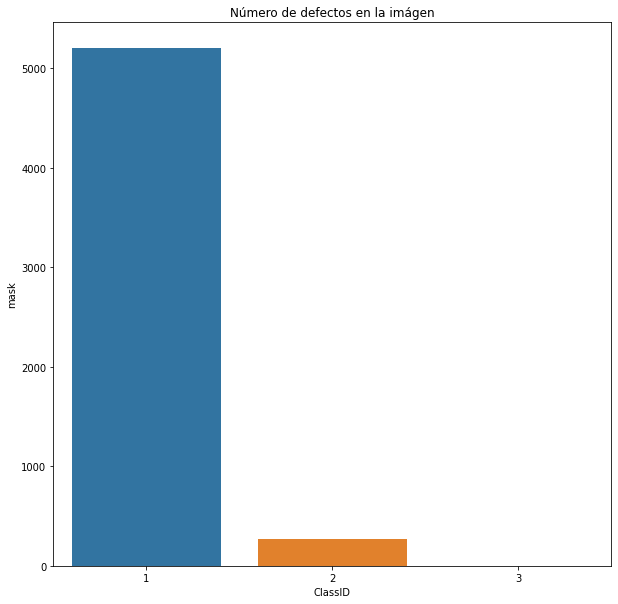

In [18]:
#Se hace un gráfico de barras en el que se muestra el número imágenes con base en el número de defectos que tenga la imágen
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Número de defectos en la imágen')
plt.show()

In [19]:
#Se imprimen las dimensiones del dataframe de imágenes defectuosas, que estan etiquetadas por el tipo de defecto
defect_class_mask_df.shape

(5748, 4)

In [20]:
#Se imprimen las dimensiones del dataframe de las imágenes defectuosas y no defectuosas
all_images_df.shape

(12997, 2)

In [21]:
# Contemos imágenes con y sin defectos
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

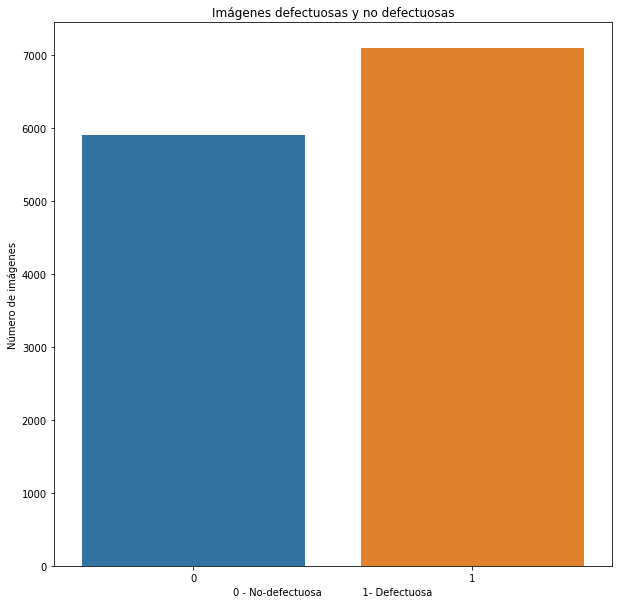

In [22]:
#Se hace un gráfico de barras en el que se muestra el número de imágenes con base en si es defectuosa o no 
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Número de imágenes')
plt.xlabel('0 - No-defectuosa             1- Defectuosa')
plt.title('Imágenes defectuosas y no defectuosas')
plt.show()

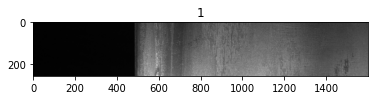

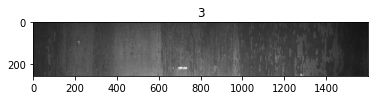

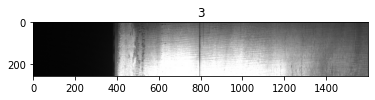

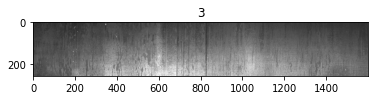

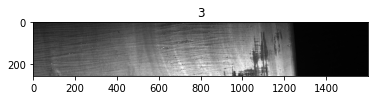

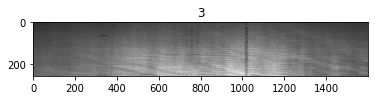

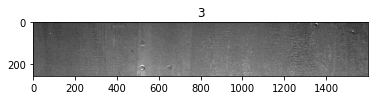

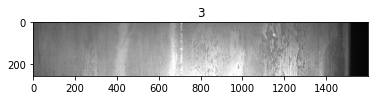

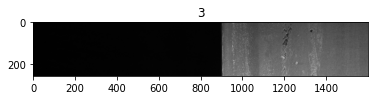

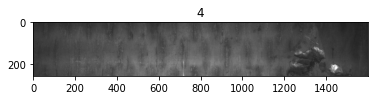

In [24]:
# Visualizar imágenes con defectos junto con sus etiquetas correspondientes
# Las imágenes son de 256 x 1600
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/MyDrive/Proyecto_Introducción_Inteligencia_Artificial_Ejemplo_1/train_images'

for i in range(10):
  # Especificar el path de las imágenes a partir de su ID de imagen
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)

In [27]:
# El archivo de Utilities contiene el código de las funciones rle2mask, mask2rle, función de pérdida personalizada y generador de datos personalizados
# dado que los datos proporcionados para la segmentación están en formato RLE (run length encoded), usaremos la siguiente función para convertir el RLE a máscara.
# podemos convertir la máscara nuevamente a RLE para evaluar el rendimiento del modelo (accuracy).
# El código fuente para estas funciones se obtuvo de: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

%cd /content/drive/MyDrive/Proyecto_Introducción_Inteligencia_Artificial_Ejemplo_1
from utilities import rle2mask , mask2rle

train_dir = '/content/drive/MyDrive/Proyecto_Introducción_Inteligencia_Artificial_Ejemplo_1/train_images'

/content/drive/MyDrive/Proyecto_Introducción_Inteligencia_Artificial_Ejemplo_1


In [ ]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [28]:
# Intentemos usar rle2mask en un imagen de prueba
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

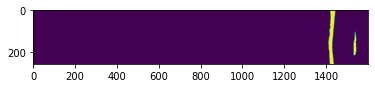

In [29]:
# Veamos la máscara
plt.imshow(mask)

(256, 1600, 3)

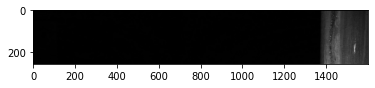

In [30]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

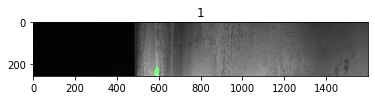

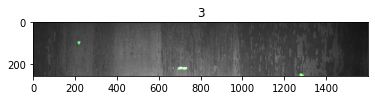

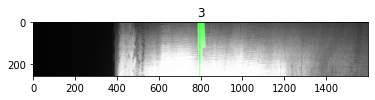

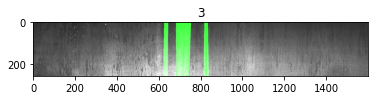

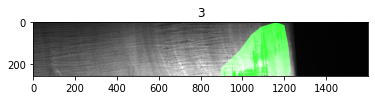

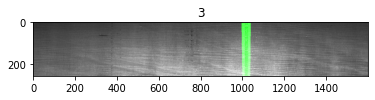

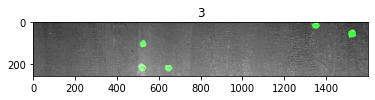

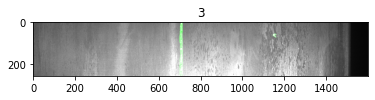

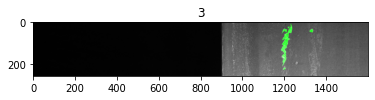

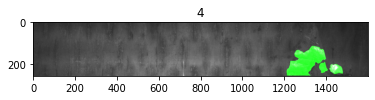

In [31]:
for i in range(10):

  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the mask for the image from rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
  
  # Let's color the pixels with values = 1 
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])

#Construcción y entrenamiento de un modelo de deep learning para detectar la presencia o ausencia de un defecto en una imagen, es decir, vamos a hacer un modelo de clasificación

In [32]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [33]:
# Dividir el dataset (defective and non defective)  en entrenamiento y testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [34]:
train.shape

(11047, 2)

In [35]:
test.shape

(1950, 2)

In [37]:
train_dir = '/content/drive/MyDrive/Proyecto_Introducción_Inteligencia_Artificial_Ejemplo_1/train_images'

In [38]:
# Crear un generador de imágenes para el conjunto de datos de entrenamiento y validación
# Dividiremos los datos en entrenamiento, validación y testing.
# Training = 9390 
# validation = 1657 
# testing = 1950 

from keras_preprocessing.image import ImageDataGenerator

# Crear un generador de datos que escale los datos de 0 a 1 y hacer una división de validación de 0,15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))

Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [39]:
# Crear un generador de datos para imágenes de test
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))


Found 1950 validated image filenames.


In [40]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94781440/94765736 [==============================] - 0s 0us/step


In [41]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [42]:
# Congelar los pesos del modelo
for layer in basemodel.layers:
  layers.trainable = False

In [43]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [44]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

##Generación de checkpoints

In [45]:
# Usar la parada temprana para parar el entrenamiento si la pérdida en validación no baja después de un cierto número de epochs (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el modelo con menor error de validación
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

#Verificar disponibilidad de una GPU

In [46]:
nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('GPU encontrada: {}'.format(nombre_gpu))

GPU encontrada: /device:GPU:0


#Entrenamiento con GPU

In [47]:
import timeit

def entrenamiento_gpu():
  with tf.device('/device:GPU:0'):
    model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])
  
  return None

gpu_time = timeit.timeit('entrenamiento_gpu()', number=1, setup='from __main__ import entrenamiento_gpu')


Epoch 1/40
586/586 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.7266
Epoch 1: val_loss improved from inf to 0.68656, saving model to resnet-weights.hdf5
586/586 [==============================] - 2669s 5s/step - loss: 0.6148 - accuracy: 0.7266 - val_loss: 0.6866 - val_accuracy: 0.5407
Epoch 2/40
586/586 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8049
Epoch 2: val_loss improved from 0.68656 to 0.62754, saving model to resnet-weights.hdf5
586/586 [==============================] - 152s 259ms/step - loss: 0.4244 - accuracy: 0.8049 - val_loss: 0.6275 - val_accuracy: 0.5583
Epoch 3/40
586/586 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8266
Epoch 3: val_loss improved from 0.62754 to 0.43368, saving model to resnet-weights.hdf5
586/586 [==============================] - 154s 262ms/step - loss: 0.3906 - accuracy: 0.8266 - val_loss: 0.4337 - val_accuracy: 0.8064
Epoch 4/40
586/586 [=============================

In [48]:
# Guardamos la arquitectura del modelo entrenado

model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

#Evaluación de la calidad del modelo

In [54]:
with open('/content/drive/MyDrive/Proyecto_Introducción_Inteligencia_Artificial_Ejemplo_1/resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargamos el modelo 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/MyDrive/Proyecto_Introducción_Inteligencia_Artificial_Ejemplo_1/resnet-weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [55]:
# Hacemos la predicción (CUIDADO TARDA MUCHO TIEMPO (~10 mins)!)

from keras_preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

121/121 [==============================] - 487s 4s/step


In [56]:
test_predict

array([[9.5858294e-01],
       [5.7138610e-01],
       [4.2011152e-12],
       ...,
       [9.9999988e-01],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [57]:
# Dado que usamos la función de activación sigmoidea al final, nuestro resultado contiene valores continuos de 0 a 1.
# La red se usa inicialmente para clasificar si la imagen tiene defecto o no
# Luego, estas imágenes (defectuosas) se pasan por la red de segmentación para obtener la ubicación y el tipo de defecto.
# Vamos a elegir 0.01, para asegurarnos de que omitimos las imágenes para que no pasen por la red de segmentación a menos que
# estemos muy seguros de que no tiene ningún defecto y si no estamos seguros, podemos pasar esta imagen a través de la red de segmentación.


predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [58]:
len(predict)

1936

In [59]:
# como usamos el generador de prueba, limitó las imágenes a 1936, debido al tamaño del lote

original = np.asarray(test.label)[:1936]
len(original)

1936

In [60]:
# Buscamos la accuracy del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8615702479338843

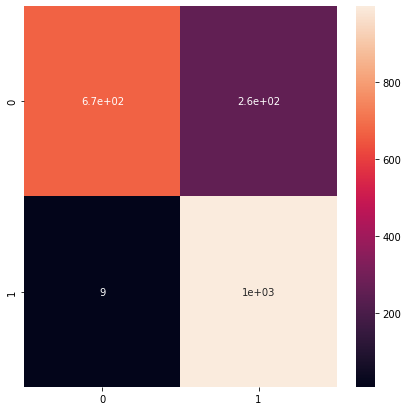

In [62]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [63]:
# Imprimimos el reporte de clasificación

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       931
           1       0.79      0.99      0.88      1005

    accuracy                           0.86      1936
   macro avg       0.89      0.86      0.86      1936
weighted avg       0.89      0.86      0.86      1936

